# Better patch ceration / combination strategy

In [6]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import torch
!pip install open3d 1>/dev/null
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim as optim
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

!pip install ipympl 1>/dev/null
%matplotlib widget

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

In [ ]:
!pip install torch-geometric

In [71]:
!pip install scipy

## Dataset

In [166]:
# %cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
from visuals.visuals_util import visualize_pointcloud, visualize_pointcloud_eval, visualize_pointcloud_eval_three
from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD
import itertools
from tqdm import tqdm

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [12]:
N_POINTS = 2048
N_POINTS_PATCH = 512

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=N_POINTS,
    te_sample_size=N_POINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


## Existing patching

In [5]:
from pytorch3d.ops import knn_points
import torch

def ball_query_batch(batch, N, selected_points):
    # Find N nearest neighbors using PyTorch3D's knn_points
    # The 'p1' points are the randomly selected points, and 'p2' are the points in the batch
    batch_size, num_points, num_channels = batch.shape
    knn = knn_points(selected_points, batch, K=N)

    # Extract the indices of the nearest neighbors
    neighbor_indices = knn.idx.squeeze(1)  # Reshape to [batch_size, N]

    # Gather the nearest neighbors from the batch
    return torch.stack([batch[i].index_select(0, neighbor_indices[i]) for i in range(batch_size)])


def random_ball_query(batch, N):
    """
    For each point cloud in the batch, select a random point and find its N nearest neighbors using PyTorch3D.

    :param batch: Tensor of size [batch_size, num_points, num_channels]
    :param N: Number of nearest neighbors to find
    :return: Tensor of nearest neighbors of size [batch_size, N, num_channels] and points used for querying
    """
    batch_size, num_points, num_channels = batch.shape

    # Randomly select a point from each point cloud
    random_indices = torch.randint(num_points, (batch_size,))
    selected_points = batch[torch.arange(batch_size), random_indices].unsqueeze(1)

    return ball_query_batch(batch, N, selected_points), selected_points


def generate_non_overlapping_patches(batch, patch_size=512):
    """
    Generate non-overlapping patches from a point cloud batch.

    :param batch: Tensor of size [batch_size, num_points, num_channels]
    :param patch_size: Size of each patch
    :return: A list of 4 tensors, each of size [batch_size, patch_size, num_channels]
    """
    batch_size, num_points, _ = batch.shape

    assert num_points % patch_size == 0
    iterations = num_points // patch_size

    input = batch.clone()

    patches = []
    for i in range(iterations - 1):
        # Use the existing function to get a patch from this section
        patch, indicies = get_nearest_neighbors_batch_pytorch3d_indicies(input, patch_size)

        # Remove the selected points
        # Create a mask with all True values
        mask = torch.ones(input.shape[:2], dtype=torch.bool)

        # Iterate over each batch to update the mask
        for i in range(indicies.shape[0]):
            mask[i, indicies[i]] = False

        # Apply the mask to the input tensor
        # The mask is broadcasted to match the shape of input_tensor
        input = input[mask].view(20, -1, 3)

        patches.append(patch)

    patches.append(input)

    return torch.stack(patches)

In [72]:
import numpy as np

def print_statistical_summary(values):
    """
    Prints the statistical summary of a list of integer values.

    Parameters:
    - values: List[int]. A list of integer values.

    The summary includes the mean, standard deviation, minimum, maximum,
    and the 10th and 90th percentiles.
    """
    # Ensuring the input is a numpy array for efficient computation
    values_array = np.array(values)

    # Calculating statistical metrics
    mean_val = np.mean(values_array)
    std_val = np.std(values_array, ddof=0)  # Population std; set ddof=1 for sample std
    min_val = np.min(values_array)
    max_val = np.max(values_array)
    percentile_10 = np.percentile(values_array, 10)
    percentile_90 = np.percentile(values_array, 90)

    # Printing the statistical summary
    print(f"Mean: {mean_val}")
    print(f"Standard Deviation: {std_val}")
    print(f"Minimum: {min_val}")
    print(f"Maximum: {max_val}")
    print(f"10th Percentile: {percentile_10}")
    print(f"90th Percentile: {percentile_90}")

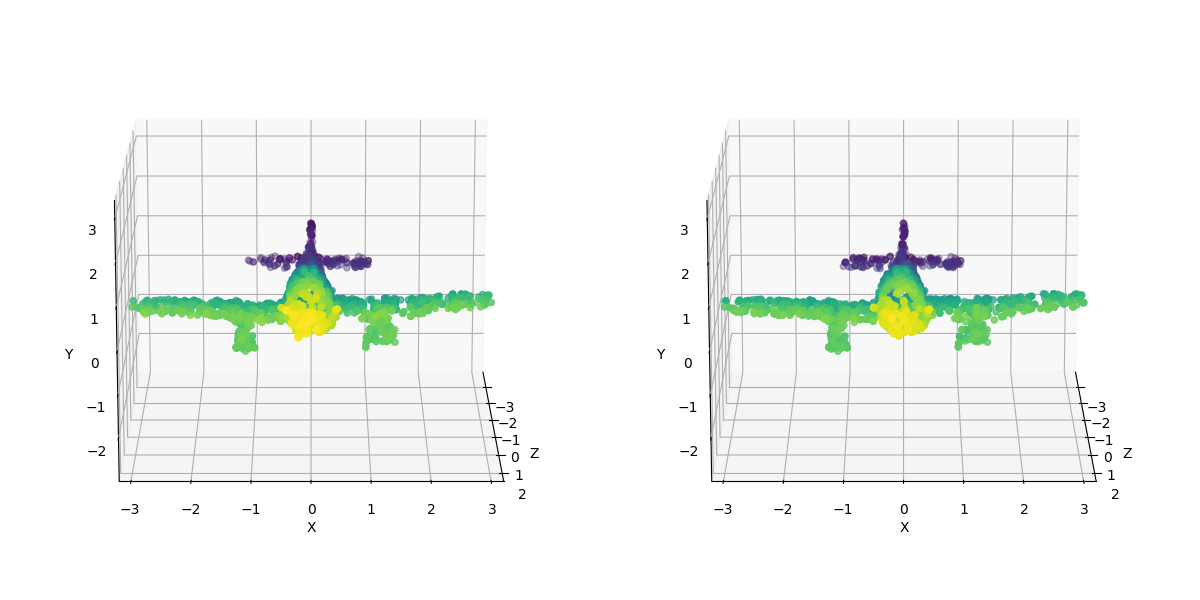

In [39]:
pc = dataset_pvd[0]['train_points']
_ = visualize_pointcloud_eval(pc, dataset_pvd[0]['test_points'])

In [95]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix


def pointcloud_kn_graph(point_cloud: np.ndarray, k=10):
  A = kneighbors_graph(point_cloud, n_neighbors=k, include_self=True, mode='distance')
  A = A.tocsr()
  return A

def generate_patches(point_cloud: torch.Tensor, patch_size, k=10):
  assert point_cloud.shape[0] % patch_size == 0, "point_cloud size not a multiple of patch_size"
  n_clusters = point_cloud.shape[0] // patch_size
  pc_np = point_cloud.detach().numpy()

  is_connected = False
  while not is_connected:
    # k-NN graph
    A = pointcloud_kn_graph(pc_np, k)
    n_components, labels_components = connected_components(csgraph=A, directed=False, return_labels=True)
    is_connected = n_components == 1
    if not is_connected:
      print(f"graph not connected for {k} increasing it to {(k:=k*2)} to connect the graph")

  # Ensure symmetrization
  A = csr_matrix(A)
  A = csr_matrix.maximum(A, A.T)


  # Spectral clustering
  clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans', random_state=0)
  labels = clustering.fit_predict(A)

  patches = [pc_np[labels == i] for i in range(n_clusters)]

  # Convert patches back to PyTorch tensors if needed
  return [torch.tensor(patch, dtype=torch.float).to(point_cloud.device) for patch in patches]

In [96]:
for pc in itertools.islice(dataset_pvd, 10):
  patches = generate_patches(pc['train_points'], N_POINTS_PATCH)

10
graph not connected for 10 increasing it to 20 to connect the graph
20


In [185]:
for i in [16, 32, 64, 128, 256, 512]:
  shapes = []
  for pc in tqdm(itertools.islice(dataset_pvd, 100)):
    shapes.extend([p.shape[0] for p in generate_patches(pc['train_points'], N_POINTS_PATCH, k=i)])
  print(f'i={i}')
  print_statistical_summary(shapes)

71it [00:36,  1.64it/s]

16
graph not connected for 16 increasing it to 32 to connect the graph
32


80it [00:40,  2.12it/s]

16
graph not connected for 16 increasing it to 32 to connect the graph
32


100it [00:51,  1.93it/s]


i=16
Mean: 512.0
Standard Deviation: 297.349205480694
Minimum: 45
Maximum: 1376
10th Percentile: 203.8
90th Percentile: 1019.5000000000001


100it [00:53,  1.86it/s]


i=32
Mean: 512.0
Standard Deviation: 254.5060903004091
Minimum: 115
Maximum: 1185
10th Percentile: 239.9
90th Percentile: 917.1


100it [00:58,  1.71it/s]


i=64
Mean: 512.0
Standard Deviation: 245.89651278535854
Minimum: 128
Maximum: 1298
10th Percentile: 259.70000000000005
90th Percentile: 903.2000000000003


100it [01:10,  1.43it/s]


i=128
Mean: 512.0
Standard Deviation: 199.50285712239813
Minimum: 208
Maximum: 1072
10th Percentile: 305.0
90th Percentile: 843.2


100it [01:32,  1.08it/s]


i=256
Mean: 512.0
Standard Deviation: 125.43880978389424
Minimum: 273
Maximum: 956
10th Percentile: 363.9
90th Percentile: 688.0


100it [02:50,  1.70s/it]

i=512
Mean: 512.0
Standard Deviation: 44.636700146852256
Minimum: 307
Maximum: 655
10th Percentile: 463.0
90th Percentile: 560.1


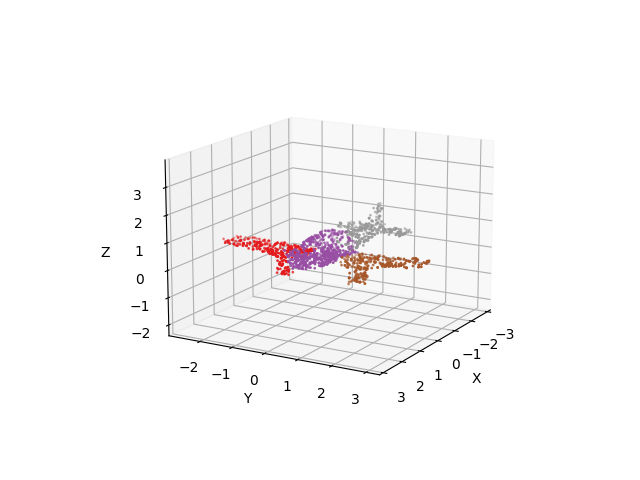

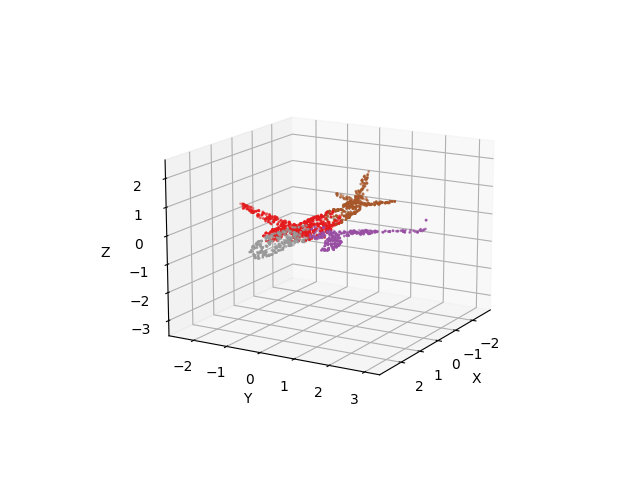

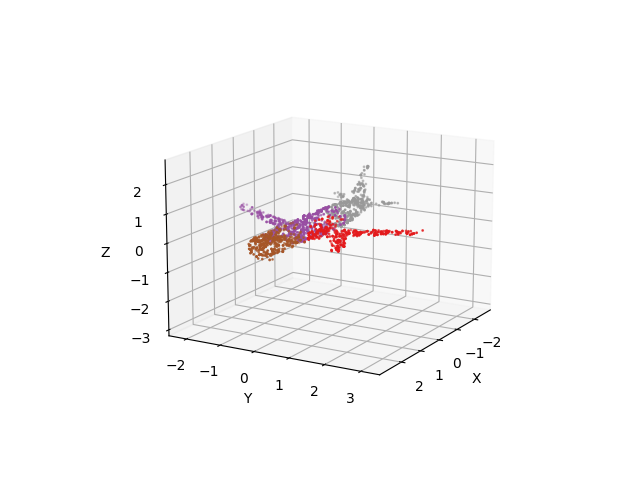

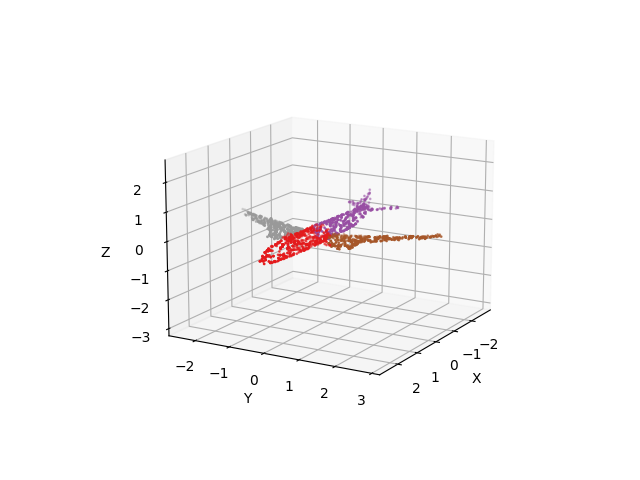

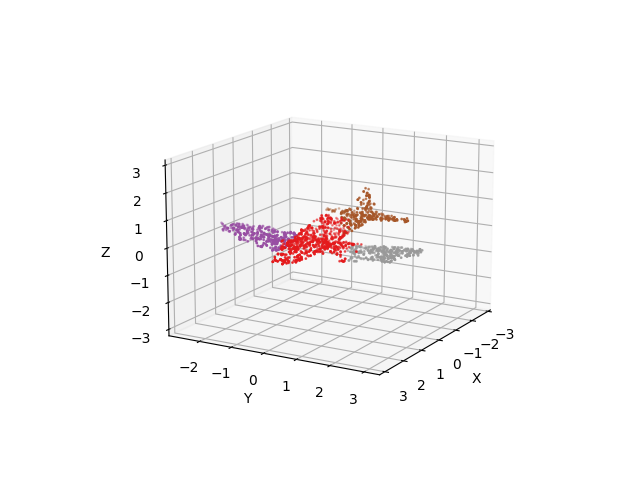

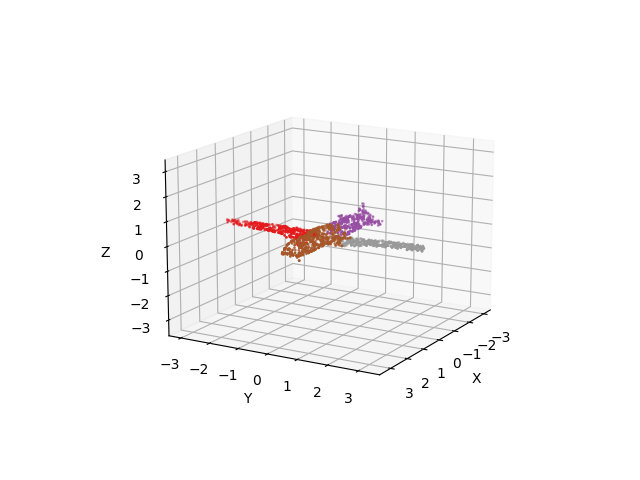

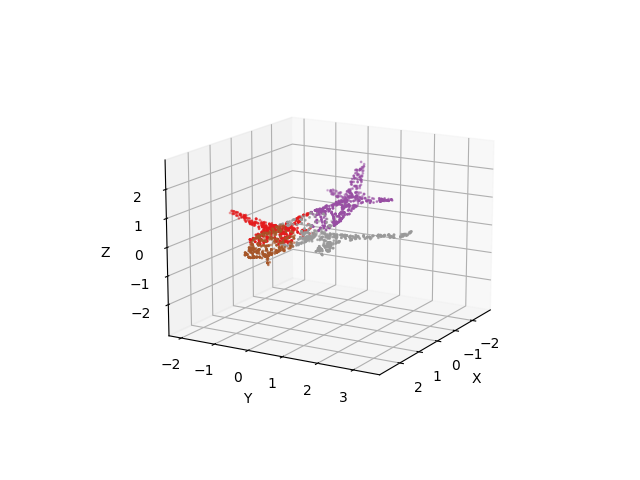

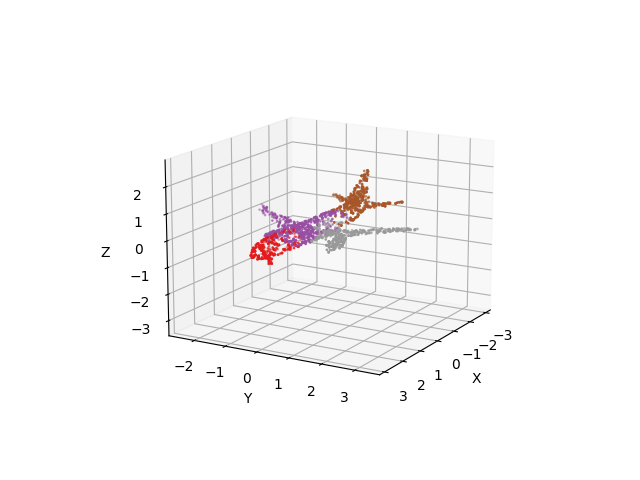

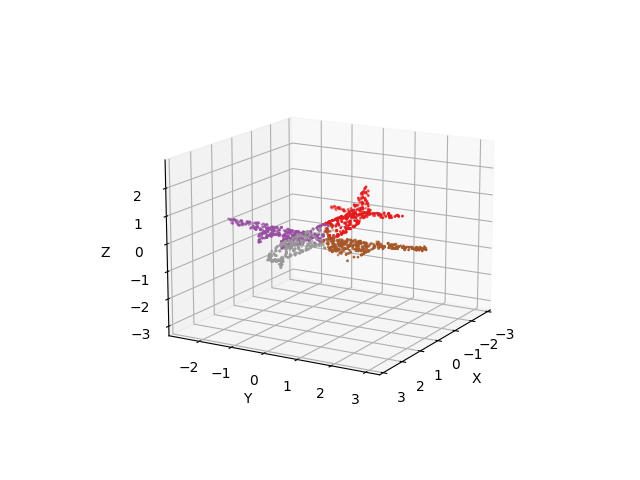

In [ ]:
for pc in itertools.islice(dataset_pvd, 10):
  patches = generate_patches(pc['train_points'], N_POINTS_PATCH, k=256)
  visualize_pointcloud_patches(patches)

Mean: 257.5
Standard Deviation: 323.7140327511305
Minimum: 3
Maximum: 1296
10th Percentile: 3.0
90th Percentile: 734.0000000000008


In [164]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_y

def visualize_pointcloud_patches(
    pcs: List[np.ndarray],
    title: str = "",
    show_axis: bool = True,
) -> plt.Figure:
    """Visualize the given list of pointclouds, each in a different color.

    Args:
        pcs (List[np.ndarray]): List of point clouds in Nx3 format.
        title (str, optional): Diagram title. Defaults to "".
        show_axis (bool, optional): Show axis and background. Defaults to True.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d", facecolor="none")

    cmap = plt.get_cmap('Set1', len(pcs))

    # Concatenate all point clouds to find global min and max for axis ranges
    all_points = np.concatenate(pcs, axis=0)
    min_vals, max_vals = np.min(all_points, axis=0), np.max(all_points, axis=0)

    # Use the overall min and max to set the axis limits
    max_range = np.array([max_vals[0] - min_vals[0], max_vals[1] - min_vals[1], max_vals[2] - min_vals[2]]).max() / 2.0
    mid_x = (max_vals[0] + min_vals[0]) * 0.5
    mid_y = (max_vals[1] + min_vals[1]) * 0.5
    mid_z = (max_vals[2] + min_vals[2]) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    for i, pc in enumerate(pcs):
        pc = rotate_point_cloud_y(pc, -90)
        pc = rotate_point_cloud_x(pc, 90)
        color = cmap(i / len(pcs))
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=[color] * len(pc), s=1)  # Adjust point size as needed

    # Labels and title
    if show_axis:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(title)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.axis("off")

    ax.view_init(15, 30)

    return fig

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [ ]:
patched = generate_patches(dataset_pvd[0]['train_points'], N_POINTS_PATCH)
_ = visualize_pointcloud_patches(patched)
visualize_pointcloud(dataset_pvd[0]['train_points'])

In [56]:
print(patched.shape)

torch.Size([2048, 3])


In [ ]:
shapes = [[p.shape for p in generate_patches(pc['train_points'], N_POINTS_PATCH)] for pc in dataset_pvd]

In [70]:
sizes = [s[0] for s in shapes]

In [73]:
print_statistical_summary(sizes)

Mean: 335.56125
Standard Deviation: 424.3676192270535
Minimum: 3
Maximum: 1650
10th Percentile: 3.0
90th Percentile: 1056.3000000000002


TODO:
- [ ] check shapes of generated point clouds

In [ ]:
for pc in itertools.islice(dataset_pvd, 5):
  pc = pc['train_points']
  for patch in generate_patches(pc, N_POINTS_PATCH):
    visualize_pointcloud_eval(pc, patch)